# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [189]:
#импортируем все необходимые для работы библиотеки, а также функции и модели для задачи классификации

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt 

In [190]:
#откроем и изучим файл

data = pd.read_csv('/datasets/users_behavior.csv')
data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Где для каждого пользователя (объекта):
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [191]:
data.info() #посмотрим на заполненность таблицы и верные ли типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Пропусков нет, но для столбцов `messages` и `calls` будет корректным установить тип int.

In [192]:
data['messages'] = data['messages'].astype('int')
data['calls'] = data['calls'].astype('int')

In [193]:
data.describe() #посмотрим на средний профиль

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


По медиане можно сделать вывод, что средний клиент совершает в месяц 62 звонка, звонков на 430 минут, отправляет 30 смс и использует около 17 Гб интернет-трафика. 

Text(0.5, 1.0, 'Распределение использованного трафика')

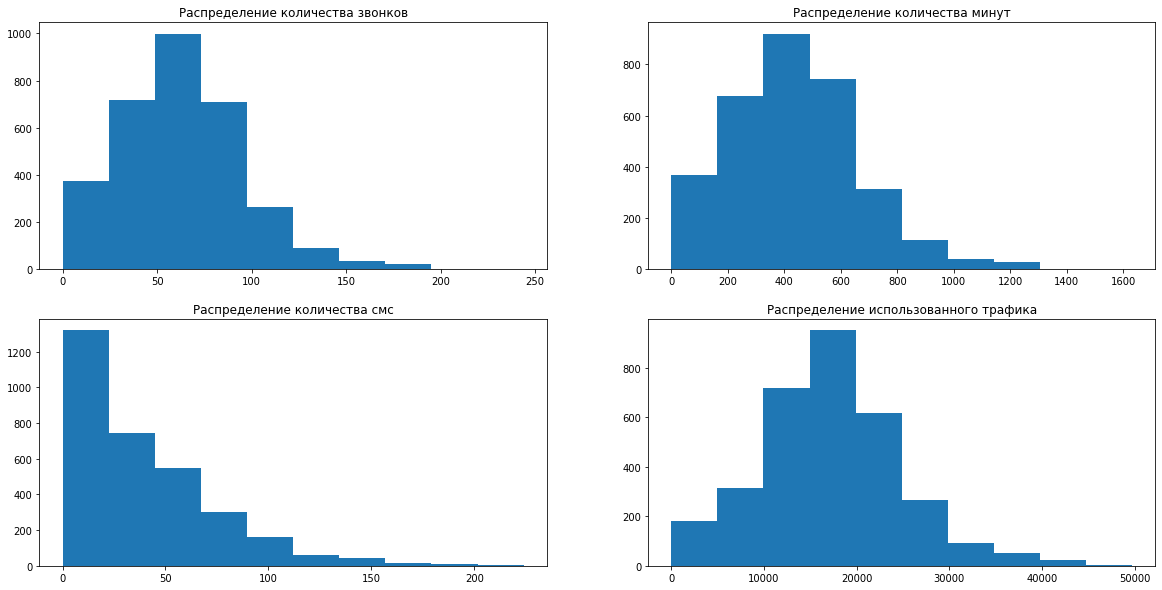

In [194]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].hist(data['calls'])
axs[0,0].set_title('Распределение количества звонков')
axs[0,1].hist(data['minutes'])
axs[0,1].set_title('Распределение количества минут')
axs[1,0].hist(data['messages'])
axs[1,0].set_title('Распределение количества смс')
axs[1,1].hist(data['mb_used'])
axs[1,1].set_title('Распределение использованного трафика')

По графикам видно, что у звонков, минут и интернет-трафика нормальные распределения. У смс ожидаемый скос влево, так как уже довольно давно люди отказались от смс в пользу мессенджеров.

## Разбейте данные на выборки

In [195]:
#нам нужно разбить данные на 3 выборки в соотношении 3 : 1 : 1 
#(60 % - обучающая выборка, 20 % - валидационная выборка, 20 % - тестовая выборка)

data_train, data_valid_test = train_test_split(data, test_size=0.4, random_state=12345) 
data_valid, data_test = train_test_split(data_valid_test, test_size=0.5, random_state=12345)

print(data_train.shape)
print(data_test.shape)
print(data_valid.shape)

(1928, 5)
(643, 5)
(643, 5)


In [196]:
#теперь для каждой из выборок выделим признаки и целевой признак (features, target)
#целевой признак - тариф (столбец 'is_ultra')

features_train = data_train.drop('is_ultra', axis=1)
target_train = data_train['is_ultra']

features_valid = data_valid.drop('is_ultra', axis=1)
target_valid = data_valid['is_ultra']

features_test = data_test.drop('is_ultra', axis=1)
target_test = data_test['is_ultra']

## Исследуйте модели

Для задач классификации используются следующие модели: Решающее дерево, Случайный лес и Логистическая регрессия. Метрику качества будем оценивать на валидационной выборке.

### Решающее дерево

In [197]:
#реализуем модель с разной глубиной дерева, чтобы добиться максимального accuracy (подберём гиперпараметр)
best_accuracy = 0
best_depth = 0
accuracy_tree = []
accuracy_train = []
for depth in range(1,21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    accuracy = model.score(features_valid, target_valid)
    accuracy_train.append(model.score(features_train, target_train))
    accuracy_tree.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_depth = depth
print(f'Наилучшее полученное качество модели: {best_accuracy}, \nГлубина дерева при наивысшем качестве модели: {best_depth}')

Наилучшее полученное качество модели: 0.7853810264385692, 
Глубина дерева при наивысшем качестве модели: 3


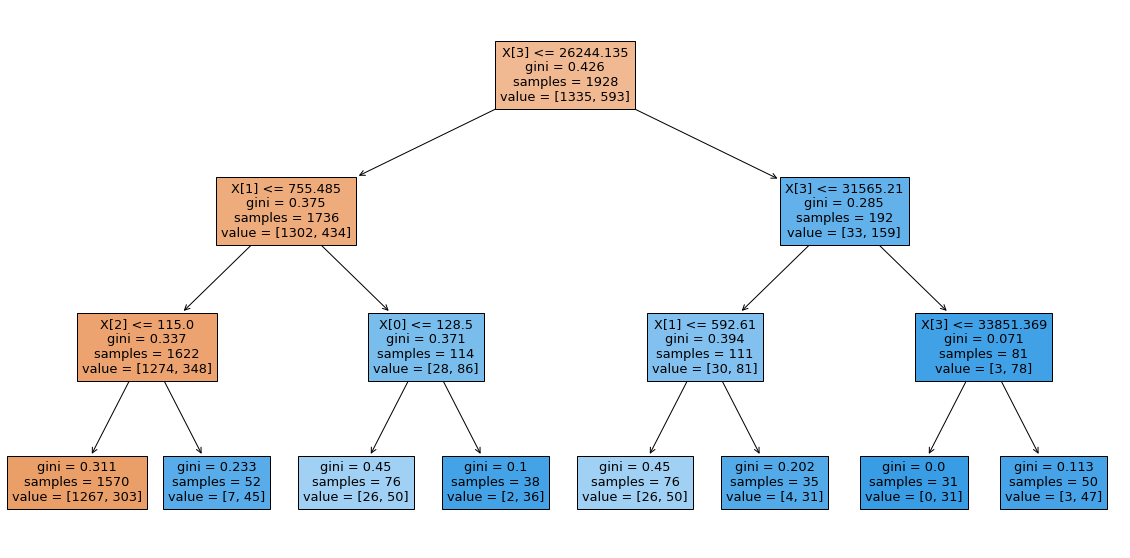

In [198]:
#визуализация разделения в дереве и принятия решений для глубины 3

plt.figure(figsize=(20, 10))
tree = DecisionTreeClassifier(max_depth=3, random_state=12345).fit(features_train, target_train)
plot_tree(tree, filled=True)
plt.show()

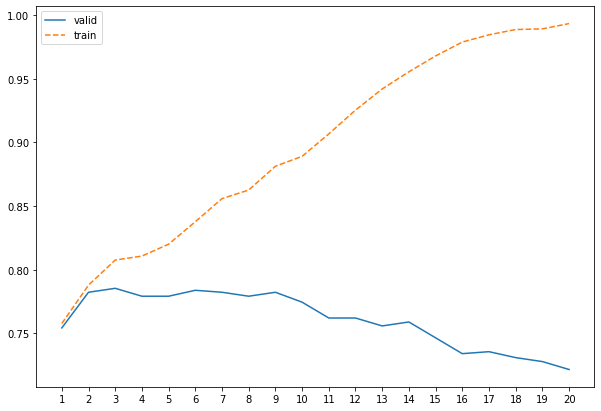

In [199]:
#посмотрим, как менялась метрика accuracy при переборе глубины


depth_tree = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
fig, ax = plt.subplots(figsize=(10, 7))
plt.xticks(depth_tree)
ax.plot(depth_tree, accuracy_tree, '-', label = 'valid')
ax.plot(depth_tree, accuracy_train, '--', label = 'train')
ax.legend()

### Случайный лес

In [200]:
#для этой модели подбираемые гиперпараметры: количество деревьев, глубина деревьев и минимальное количество объектов в узле

best_accuracy = 0
best_depth = 0
best_est = 0
best_sample = 0
for depth in range(1,11):
    for est in range(5,51,5):
        for sample in range(2,6):
            model = RandomForestClassifier(max_depth=depth, n_estimators=est, min_samples_leaf=sample, random_state=12345)
            model.fit(features_train, target_train)
            accuracy = model.score(features_valid, target_valid)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_depth = depth
                best_est = est
                best_sample = sample
print(f'Наилучшее полученное качество модели: {best_accuracy} \nГлубина дерева при наивысшем качестве модели: {best_depth} \nКоличество деревьев в лесу с наилучшим accuracy: {best_est} \nМинимальное количество объектов в узле: {best_sample}')

Наилучшее полученное качество модели: 0.8087091757387247 
Глубина дерева при наивысшем качестве модели: 6 
Количество деревьев в лесу с наилучшим accuracy: 35 
Минимальное количество объектов в узле: 2


### Логистическая регрессия

In [201]:
#реализуем модель с разным максимальным числом итераций, чтобы добиться максимального accuracy (подберём гиперпараметр)
best_accuracy = 0
best_iter = 0
for iteration in range(100, 1000, 50):
    model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=iteration)
    model.fit(features_train, target_train)
    accuracy = model.score(features_valid, target_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_iter = iteration
print(f'Наилучшее полученное качество модели: {best_accuracy}, \nМаксимальное число итераций при наивысшем качестве модели: {best_iter}')

Наилучшее полученное качество модели: 0.7107309486780715, 
Максимальное число итераций при наивысшем качестве модели: 100


**Вывод:**
Наивысшее качество показала модель 'Случайный лес', при этом скорость работы у модели самая низкая. Метрика accuracy достигла 0.8087091757387247 при:
* max_depth = 6 (глубина деревьев)
* n_estimators = 35 (количество деревьев) 
* min_samples_leaf = 2 (минимальное количество объектов в узле).

Худший результат показала модель 'Логистическая регрессия'.

## Проверьте модель на тестовой выборке

Так как наилучший результат показала модель Случайный лес, то на тестовой выборке будем проверять именно её при всех определенных гиперпараметрах. 

In [202]:
model = RandomForestClassifier(random_state=12345, n_estimators=35, max_depth=6, min_samples_leaf = 2)
model.fit(features_train, target_train)
test_predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, test_predictions)
print('Accuracy для тестовой выборки:', accuracy)

Accuracy для тестовой выборки: 0.7962674961119751


Для тестовой выборки accuracy составило 0.7962674961119751, что довольно близко к полученному на валидационной выборке для этой модели. И результат соответствует цели: полученная метрика больше, чем 0.75. 

In [203]:
#precision (точность) - метрика, показывающая, какая доля объектов, спрогнозированных моделью как "1", действительно являются таковыми.
precision_score(target_test, test_predictions)

0.7857142857142857

In [204]:
#recall (полнота) - метрика, выявляющая, какую долю объектов класса "1" из всех объектов положительного класса нашел алгоритм
recall_score(target_test, test_predictions)

0.4876847290640394

## (бонус) Проверьте модели на адекватность

In [205]:
#попробуем остальные модели на тестовой выборке

model = DecisionTreeClassifier(random_state=12345, max_depth=3)
model.fit(features_train, target_train)
test_predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, test_predictions)
print('Accuracy для тестовой выборки при использовании модели "Решающее дерево":', accuracy)

Accuracy для тестовой выборки при использовании модели "Решающее дерево": 0.7791601866251944


In [206]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100)
model.fit(features_train, target_train)
test_predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, test_predictions)
print('Accuracy для тестовой выборки при использовании модели "Логистическая регрессия":', accuracy)

Accuracy для тестовой выборки при использовании модели "Логистическая регрессия": 0.6842923794712286


Проверив остальные 2 модели на тестовой выборке, получили результаты хуже, чем при использовании модели "Случайный лес", как и на валидационной выборке. Поэтому модель выбрана была верно.  

In [207]:
# посмотрим на то, какое количество обоих тарифных планов было предсказано и какое было в исходной тестовой выборке

target_test.value_counts()

0    440
1    203
Name: is_ultra, dtype: int64

In [208]:
model = RandomForestClassifier(random_state=12345, n_estimators=35, max_depth=6, min_samples_leaf = 2)
model.fit(features_train, target_train)
test_predictions = model.predict(features_test)
pd.Series(test_predictions).value_counts()

0    517
1    126
dtype: int64

Итак, 0 - это тариф "Смарт", а 1 - тариф "Ультра". 

В исходных тестовых данных доля тарифа "Смарт" составляет 68.4%, а в предсказании 80.4%.
"Ультра" в тестовой выборке составляет 31.6%, а в предсказании 19.6%.
Возможно, это может быть связано с тем, что в обучающей выборке тарифа "Смарт" больше. Проверим.

In [209]:
target_train.value_counts()

0    1335
1     593
Name: is_ultra, dtype: int64

Да, действительно, тарифа "Смарт" в 2.25 раз больше, чем "Ультра". То есть имеется дисбаланс в обучающей выборке. Поэтому модель обучается чаще давать в качестве результата "1".

In [210]:
model = RandomForestClassifier(random_state=12345, n_estimators=35, max_depth=6, min_samples_leaf = 2)
model.fit(features_train, target_train)
test_predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, test_predictions)
print('Accuracy для тестовой выборки:', accuracy)

Accuracy для тестовой выборки: 0.7962674961119751


In [211]:
simple_model = DummyClassifier(strategy='stratified' ,random_state=12345)
simple_model.fit(features_train, target_train)
simple_accuracy = simple_model.score(features_test, target_test)
print('Качество простойшего прогноза:', simple_accuracy)
print('Качество нашего прогноза:', accuracy)

Качество простойшего прогноза: 0.536547433903577
Качество нашего прогноза: 0.7962674961119751


In [212]:
#попробуем с иной стратегией
simple_model = DummyClassifier(strategy='uniform' ,random_state=12345)
simple_model.fit(features_train, target_train)
simple_accuracy = simple_model.score(features_test, target_test)
print('Качество простойшего прогноза:', simple_accuracy)
print('Качество нашего прогноза:', accuracy)

Качество простойшего прогноза: 0.4821150855365474
Качество нашего прогноза: 0.7962674961119751


Сравнив выбранную для результирующего прогноза модель с простейшей, можно сделать вывод, что модель адекватная, её accuracy значительно превышает accuracy простейшей модели с двумя разными стратегиями.
Также создадим обучающую выборку без дисбаланса в целевом признаке.

In [213]:
data_ultra = data_train.query('is_ultra == 1')
data_smart = data_train.query('is_ultra == 0').head(593)
balance = [data_ultra, data_smart]
data_train_new = pd.concat(balance)

data_train_new['is_ultra'].value_counts()

0    593
1    593
Name: is_ultra, dtype: int64

In [214]:
model = RandomForestClassifier(random_state=12345, n_estimators=35, max_depth=6, min_samples_leaf = 2)
model.fit(features_train, target_train)
test_predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, test_predictions)
print('Accuracy для тестовой выборки:', accuracy)

Accuracy для тестовой выборки: 0.7962674961119751


In [215]:
#теперь обучим выбранную модель с подобранными гиперпараметрами на новом наборе данных без дисбаланса и проверим accuracy на тестовой выборке
features_train_balance = data_train_new.drop('is_ultra', axis=1)
target_train_balance = data_train_new['is_ultra']
balance_model = RandomForestClassifier(random_state=12345, n_estimators=35, max_depth=6, min_samples_leaf=2)
balance_model.fit(features_train_balance, target_train_balance)
test_predictions = model.predict(features_test)
accuracy_balance = accuracy_score(target_test, test_predictions)
print('Accuracy для тестовой выборки при обучении без дисбаланса:', accuracy_balance)

Accuracy для тестовой выборки при обучении без дисбаланса: 0.7962674961119751


Метрика accuracy не отличается для обучающих выборок с дисбалансом и без него.